<a href="https://colab.research.google.com/github/JosephAlves0/dio-machine-learning-training/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow version:  2.18.0
Num GPUs Available:  1


Número de exemplos de treinamento: 18610
Número de exemplos de validação: 2326
Número de exemplos de teste: 2326


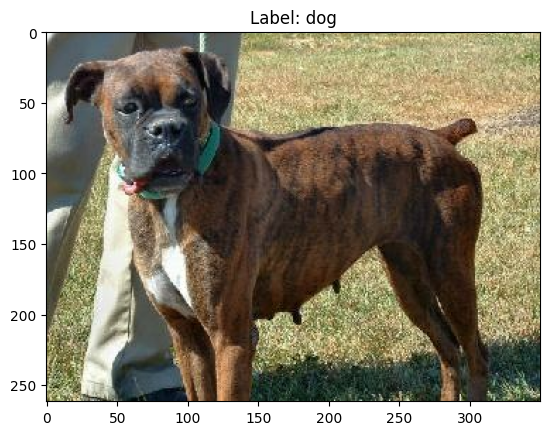

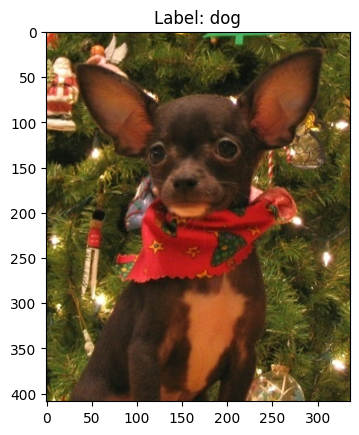

In [13]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print("Número de exemplos de treinamento:", tf.data.experimental.cardinality(raw_train).numpy())
print("Número de exemplos de validação:", tf.data.experimental.cardinality(raw_validation).numpy())
print("Número de exemplos de teste:", tf.data.experimental.cardinality(raw_test).numpy())

get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(2):
  plt.imshow(image)
  plt.title(f"Label: {get_label_name(label)}")
  plt.show()

In [14]:
IMG_SIZE = 224
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label


train_batches = raw_train.map(format_example).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = raw_validation.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = raw_test.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for image_batch, label_batch in train_batches.take(1):
    print("Forma do batch de imagens:", image_batch.shape)
    print("Forma do batch de labels:", label_batch.shape)

Forma do batch de imagens: (32, 224, 224, 3)
Forma do batch de labels: (32,)


In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
initial_epochs = 10 # Você pode ajustar este valor

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.8193 - loss: 0.4064 - val_accuracy: 0.9742 - val_loss: 0.1082
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.9763 - loss: 0.0989 - val_accuracy: 0.9815 - val_loss: 0.0700
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.9816 - loss: 0.0682 - val_accuracy: 0.9841 - val_loss: 0.0569
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.9828 - loss: 0.0571 - val_accuracy: 0.9850 - val_loss: 0.0502
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.9843 - loss: 0.0506 - val_accuracy: 0.9862 - val_loss: 0.0459
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/step - accuracy: 0.9852 - loss: 0.0456 - val_accuracy: 0.9862 - val_loss: 0.0433
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.9855 - loss: 0.0430 - val_accuracy: 0.9862 - val_loss: 0.0414
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.9882 - loss: 0.0395 - 

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9929 - loss: 0.0264
Loss no conjunto de teste: 0.0282
Acurácia no conjunto de teste: 0.9914


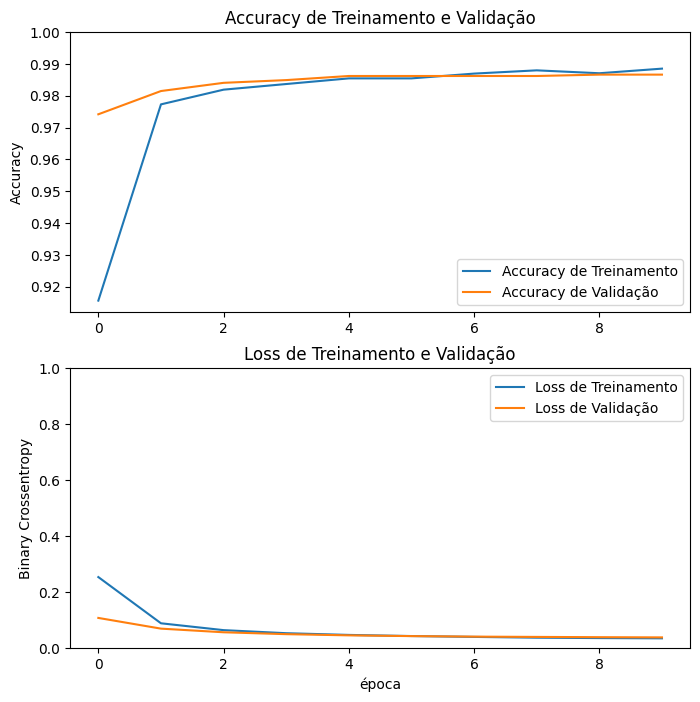

In [18]:
loss, accuracy = model.evaluate(test_batches)
print(f"Loss no conjunto de teste: {loss:.4f}")
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Accuracy de Treinamento')
plt.plot(val_acc, label='Accuracy de Validação')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy de Treinamento e Validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Loss de Treinamento')
plt.plot(val_loss, label='Loss de Validação')
plt.legend(loc='upper right')
plt.ylabel('Binary Crossentropy')
plt.ylim([0,1.0])
plt.title('Loss de Treinamento e Validação')
plt.xlabel('época')
plt.show()

In [19]:
base_model.trainable = True

print("Número de camadas no modelo base:", len(base_model.layers))
print("Número de camadas treináveis após descongelamento:", len(model.trainable_variables))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Número de camadas no modelo base: 154
Número de camadas treináveis após descongelamento: 158
Epoch 10/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 148ms/step - accuracy: 0.9241 - loss: 0.1793 - val_accuracy: 0.9794 - val_loss: 0.0525
Epoch 11/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 69s 116ms/step - accuracy: 0.9790 - loss: 0.0548 - val_accuracy: 0.9871 - val_loss: 0.0390
Epoch 12/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 68s 115ms/step - accuracy: 0.9862 - loss: 0.0381 - val_accuracy: 0.9858 - val_loss: 0.0411
Epoch 13/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 68s 115ms/step - accuracy: 0.9895 - loss: 0.0323 - val_accuracy: 0.9862 - val_loss: 0.0405
Epoch 14/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - accuracy: 0.9944 - loss: 0.0200 - val_accuracy: 0.9871 - val_loss: 0.0384
Epoch 15/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.9945 - loss: 0.0167 - val_accuracy: 0.9871 - val_loss: 0.0384
Epoch 16/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 68s 115ms/step - accuracy: 0.9967 - loss: 0.0119 - val_accuracy: 0.9867 -

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9955 - loss: 0.0229
Loss no conjunto de teste (após fine-tuning): 0.0249
Acurácia no conjunto de teste (após fine-tuning): 0.9940


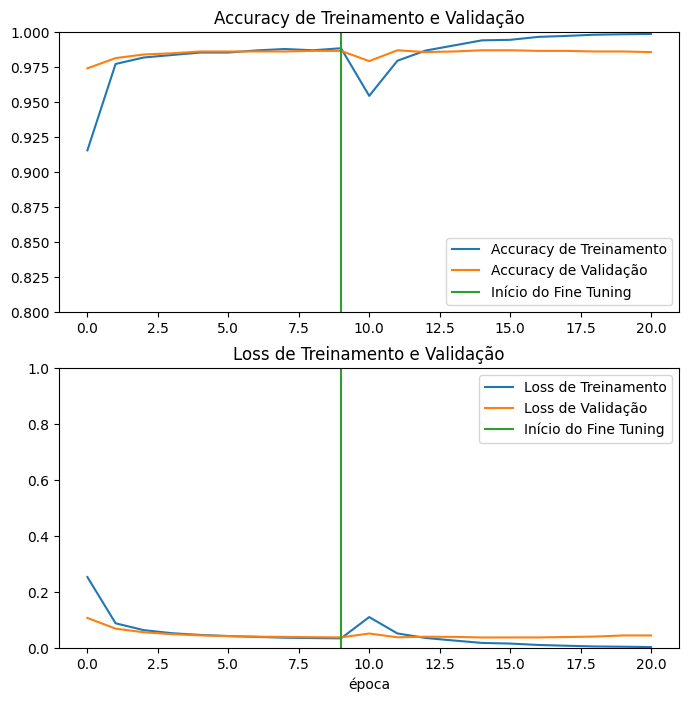

In [20]:
loss_test, accuracy_test = model.evaluate(test_batches)
print(f"Loss no conjunto de teste (após fine-tuning): {loss_test:.4f}")
print(f"Acurácia no conjunto de teste (após fine-tuning): {accuracy_test:.4f}")

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Accuracy de Treinamento')
plt.plot(val_acc, label='Accuracy de Validação')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Início do Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy de Treinamento e Validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Loss de Treinamento')
plt.plot(val_loss, label='Loss de Validação')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Início do Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss de Treinamento e Validação')
plt.xlabel('época')
plt.show()